## Using CNN for radiomics study

Import the libraries first

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math

import pydicom
from pydicom.data import get_testdata_file, get_testdata_files
from pydicom.filereader import read_dicomdir
from skimage.draw import polygon
import SimpleITK as sitk

import os, shutil
import sys
import glob
import random

And the neural network libraries

In [3]:
#import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils import to_categorical

Using TensorFlow backend.


Plan of attack:

1. Load DICOM images with segmentation as mask $\rightarrow$ done
2. Remove everything outside the mask $\rightarrow$ done
3. Set up neural network and pass it through

### Loading DICOM images

Define two functions:
(Source: http://aapmchallenges.cloudapp.net/forums/3/2/)

In [2]:
def read_structure(structure):
    contours = []

    for i in range(len(structure.ROIContourSequence)):
        # Only include GTVs
        if ("gtv" not in structure.StructureSetROISequence[i].ROIName.lower()):
            continue
        
        contour = {}
        contour['number'] = structure.ROIContourSequence[i].ReferencedROINumber
        contour['name'] = structure.StructureSetROISequence[i].ROIName
#        contour['color'] = structure.ROIContourSequence[i].ROIDisplayColor
        assert contour['number'] == structure.StructureSetROISequence[i].ROINumber
        contour['contours'] = [s.ContourData for s in structure.ROIContourSequence[i].ContourSequence]
        contours.append(contour)
        
    return contours

In [3]:
def get_mask(contours, slices, image):
    z = [s.ImagePositionPatient[2] for s in slices]
    pos_r = slices[0].ImagePositionPatient[1]
    spacing_r = slices[0].PixelSpacing[1]
    pos_c = slices[0].ImagePositionPatient[0]
    spacing_c = slices[0].PixelSpacing[0]

    label = np.zeros_like(image, dtype=np.uint8)
    
    for con in contours:
        # Original code, for distinguishing between different structures
        # num = int(con['number'])
        
        for c in con['contours']:
            nodes = np.array(c).reshape((-1, 3))
            assert np.amax(np.abs(np.diff(nodes[:, 2]))) == 0
            z_index = z.index(nodes[0, 2])
            r = (nodes[:, 1] - pos_r) / spacing_r
            c = (nodes[:, 0] - pos_c) / spacing_c
            rr, cc = polygon(r, c)
            # Original code, for distinguishing between different structures
            # label[rr, cc, z_index] = num
            label[rr, cc, z_index] = 1

#        colors = tuple(np.array([con['color'] for con in contours]) / 255.0)
#    return label, colors
    return label

Try a patient with multiple GTVs:

In [4]:
def remove_outside_mask(train_data_path):
    ct_contours_folders = [os.path.join(train_data_path, name) 
                           for name in os.listdir(train_data_path) if os.path.isdir(os.path.join(train_data_path, name))]

    # There are two folders
    # One containing the CT images
    # The other containing the contours
    # Always load the contour (RTSTRUCT) file first
    if ('CTLUNG' not in ct_contours_folders[0]):
        ct_contours_folders[1], ct_contours_folders[0] = ct_contours_folders[0], ct_contours_folders[1]

    # Then loop through each of the two folders
    for folder in ct_contours_folders:
        for subdir, dirs, files in os.walk(folder):

            dcms = glob.glob(os.path.join(subdir, "*.dcm"))

            # Do not include segmentation file
            if len(dcms) == 1:
                if ('Segmentation' not in dcms[0]):
                    structure = pydicom.read_file(os.path.join(subdir, files[0]))
                    contours = read_structure(structure)
            elif len(dcms) > 1:
                slices = [pydicom.read_file(dcm) for dcm in dcms]
                slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
                image = np.stack([s.pixel_array for s in slices], axis=-1)

                label = get_mask(contours, slices, image)
    
    # Return only the portion of the image in the mask
    masked_img = np.multiply(image, label)
    
    return masked_img

# # Plot to check slices
# plt.figure(figsize=(15, 15))
# for i in range(16):
#     plt.subplot(4, 4, i + 1)
#     plt.imshow(image[..., i+50], cmap="gray")
#     plt.contour(label[..., i+50], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors=colors)
#     plt.axis('off')

In [8]:
# Create array of patient folders
# Skip over the two patients where contours do not match with CT images
px_folder_base = "/Volumes/Time Machine Backups/Radiomics-NSCLC-v3/NSCLC-Radiomics/"
px_skip = ["LUNG1-014", "LUNG1-085"]
# Will investigate the following patients later
px_skip.append("LUNG1-058") # Out of range

# List full path for all patient folders
px_folders = [name for name in os.listdir(px_folder_base) 
              if (os.path.isdir(os.path.join(px_folder_base, name)) and 
                  name not in px_skip)]

# Array of images
masked_images = []

# Create files for masked images for future analysis
masked_folder_base = "/Volumes/Time Machine Backups/Radiomics-NSCLC-v3-masked/"

for folder in px_folders:
    img_temp = remove_outside_mask(os.path.join(px_folder_base, folder))
    
    # Create the image in the right folder
    if not os.path.exists(os.path.join(masked_folder_base, folder)):
        os.makedirs(os.path.join(masked_folder_base, folder))
    
    os.chdir(os.path.join(masked_folder_base, folder))
    
    img_temp_sitk = sitk.GetImageFromArray(img_temp)
    img_temp_sitk = sitk.Cast(img_temp_sitk, sitk.sitkUInt8)
    sitk.WriteImage(img_temp_sitk, "masked.tif")

LUNG1-001
LUNG1-002
LUNG1-003
LUNG1-004
LUNG1-005
LUNG1-006
LUNG1-007
LUNG1-008
LUNG1-009
LUNG1-010
LUNG1-011
LUNG1-012
LUNG1-013
LUNG1-015
LUNG1-016
LUNG1-017
LUNG1-018
LUNG1-019
LUNG1-020
LUNG1-021
LUNG1-022
LUNG1-023
LUNG1-024
LUNG1-025
LUNG1-026
LUNG1-027
LUNG1-028
LUNG1-029
LUNG1-030
LUNG1-031
LUNG1-032
LUNG1-033
LUNG1-034
LUNG1-035
LUNG1-036
LUNG1-037
LUNG1-038
LUNG1-039
LUNG1-040
LUNG1-041
LUNG1-042
LUNG1-043
LUNG1-044
LUNG1-045
LUNG1-046
LUNG1-047
LUNG1-048
LUNG1-049
LUNG1-050
LUNG1-051
LUNG1-052
LUNG1-053
LUNG1-054
LUNG1-055
LUNG1-056
LUNG1-057
LUNG1-059
LUNG1-060
LUNG1-061
LUNG1-062
LUNG1-063
LUNG1-064
LUNG1-065
LUNG1-066
LUNG1-067
LUNG1-068
LUNG1-069
LUNG1-070
LUNG1-071
LUNG1-072
LUNG1-073
LUNG1-074
LUNG1-075
LUNG1-076
LUNG1-077
LUNG1-078
LUNG1-079
LUNG1-080
LUNG1-081
LUNG1-082
LUNG1-083
LUNG1-084
LUNG1-086
LUNG1-087
LUNG1-088
LUNG1-089
LUNG1-090
LUNG1-091
LUNG1-092
LUNG1-093
LUNG1-094
LUNG1-095
LUNG1-096
LUNG1-097
LUNG1-098
LUNG1-099
LUNG1-100
LUNG1-101
LUNG1-102
LUNG1-103


---

### Reading the images containing the masked volume

#### 1. Classify the images according to the survival time
For the n-year survival analysis, we first select the patients where:
- they survived past the n-year mark; or
- they expired before the n-year mark

First we read the survival data:

In [4]:
masked_folder_base = "/Volumes/Time Machine Backups/Radiomics-NSCLC-v3-masked/"
df_survive = pd.read_csv(masked_folder_base + 'NSCLC Radiomics Lung1.clinical-version3-Oct 2019.csv')

In [5]:
df_survive.head()

,PatientID,age,clinical.T.Stage,Clinical.N.Stage,Clinical.M.Stage,Overall.Stage,Histology,gender,Survival.time,deadstatus.event
0,LUNG1-001,78.7515,2.0,3,0,IIIb,large cell,male,2165,1
1,LUNG1-002,83.8001,2.0,0,0,I,squamous cell carcinoma,male,155,1
2,LUNG1-003,68.1807,2.0,3,0,IIIb,large cell,male,256,1
3,LUNG1-004,70.8802,2.0,1,0,II,squamous cell carcinoma,male,141,1
4,LUNG1-005,80.4819,4.0,2,0,IIIb,squamous cell carcinoma,male,353,1


Remove the patients whose CT files have not been processed:

In [6]:
# Can comment this line if running the entire code thorugh
px_skip = ['LUNG1-014', 'LUNG1-058', 'LUNG1-085']

for skip in px_skip:
    df_survive = df_survive[df_survive['PatientID']!=skip]

Plan of attack here:
- Exclude censored patients where their survival is not known up to the timeframe studied
- Clear any existing folder structures for training and testing dataset (creating a blank slate)
- Create structure to split into training and testing
- Among training, split into patients surviving more _or_ less than the timeframe studied

Define the number of years to be studied, and skim the data applicable:

In [7]:
nyear = 5
bool_alive = df_survive['Survival.time'] > nyear*365
bool_dead = (df_survive['Survival.time'] < nyear*365) & (df_survive['deadstatus.event']) 

df_survive = df_survive[bool_alive | bool_dead]

Who are the patients in the dataset?

In [8]:
px_names = df_survive['PatientID'].unique()

Change first into the base folder for the masked images:

In [8]:
os.chdir(masked_folder_base)

Reset the directory, and define the test size (in terms of the fraction of the entire dataset):

In [9]:
# Clear previous directory structure
if os.path.exists(os.path.join(masked_folder_base, 'analysis')):
    shutil.rmtree(masked_folder_base + 'analysis/')

# Remake directory
os.makedirs('analysis/train') # patients with survival time less than the 
os.makedirs('analysis/test')

# Pick the test size, and define the test and train sets
test_size = 0.3
random.seed(1)
test_files = random.sample(px_names.tolist(), k=math.floor(test_size*len(px_names)))
train_files = [name for name in px_names if name not in test_files]

Copy the files:

In [10]:
# Copy the test files into the test sub-directory
for file in test_files:
    dst_filename = file + '.tif'
    
    src_file = os.path.join(masked_folder_base, file, 'masked.tif')
    dst_file = os.path.join(masked_folder_base, 'analysis/test', dst_filename)
    shutil.copy(src_file, dst_file)

In [11]:
# Copy the train files into the train sub-directory
for file in train_files:
    dst_filename = file + '.tif'
    
    src_file = os.path.join(masked_folder_base, file, 'masked.tif')
    dst_file = os.path.join(masked_folder_base, 'analysis/train', dst_filename)
    shutil.copy(src_file, dst_file)

Making sure the sizes are the same. In principle, all axial slices should be 512x512; only the scan length should differ.

In [9]:
# Instantiating a file reader
reader = sitk.ImageFileReader()
reader.SetImageIO("TIFFImageIO")

# Setting file name
folder_name = os.path.join(masked_folder_base, 'analysis/train')
os.chdir(folder_name)
filename_list = glob.glob('*.tif')

# Keep scan lengths in an array for later inspection
sl_list = []

for filename in filename_list:
    inputImageFileName = os.path.join(folder_name, filename)
    reader.SetFileName(inputImageFileName)
    img_tmp = reader.Execute()

    sl_list.append(img_tmp.GetSize()[0])

In [10]:
sl_list = np.array(sl_list)

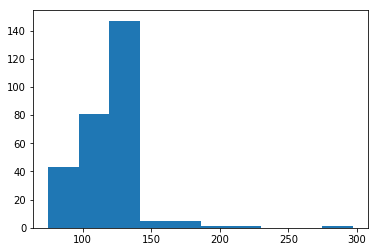

In [11]:
# Plot a histogram
plt.hist(sl_list)
plt.show()

So not all of them have the same dimensions:

In [12]:
sl_list.argmax()

69

Look at this patient:

In [13]:
reader.SetFileName(filename_list[sl_list.argmax()])
img_tmp = reader.Execute()

In [14]:
dir(img_tmp)

['CopyInformation',
 'EraseMetaData',
 'GetDepth',
 'GetDimension',
 'GetDirection',
 'GetHeight',
 'GetITKBase',
 'GetMetaData',
 'GetMetaDataKeys',
 'GetNumberOfComponentsPerPixel',
 'GetNumberOfPixels',
 'GetOrigin',
 'GetPixel',
 'GetPixelAsComplexFloat64',
 'GetPixelID',
 'GetPixelIDTypeAsString',
 'GetPixelIDValue',
 'GetSize',
 'GetSpacing',
 'GetWidth',
 'HasMetaDataKey',
 'MakeUnique',
 'SetDirection',
 'SetMetaData',
 'SetOrigin',
 'SetPixel',
 'SetPixelAsComplexFloat64',
 'SetSpacing',
 'TransformContinuousIndexToPhysicalPoint',
 'TransformIndexToPhysicalPoint',
 'TransformPhysicalPointToContinuousIndex',
 'TransformPhysicalPointToIndex',
 '__GetPixelAsComplexFloat32__',
 '__GetPixelAsDouble__',
 '__GetPixelAsFloat__',
 '__GetPixelAsInt16__',
 '__GetPixelAsInt32__',
 '__GetPixelAsInt64__',
 '__GetPixelAsInt8__',
 '__GetPixelAsUInt16__',
 '__GetPixelAsUInt32__',
 '__GetPixelAsUInt64__',
 '__GetPixelAsUInt8__',
 '__GetPixelAsVectorFloat32__',
 '__GetPixelAsVectorFloat64__',
 '

In [15]:
img_arr = sitk.GetArrayFromImage(img_tmp)

In [16]:
print(img_arr)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


Plan of attack:
- strip the zero arrays from this particular patient (?)
- and pad the remaining patients

It turns out the third dimension is the scan length, so one cannot pad by appending another array in the image array

In [23]:
img_arr[:,0,0].any()

False

---
#### Feeding it through the CNN
Then feed it through the CNN!

In [ ]:
# Create the model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=0.001),
              metrics=['accuracy'])
model.summary()

# Fit data to model
history = model.fit(X_train, targets_train,
            batch_size=128,
            epochs=40,
            verbose=1,
            validation_split=0.3)